### Import the libraries

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import datetime as dt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

### Import the data

In [2]:
train = pd.read_csv("C://Users/raghu/Desktop/Article_5/Data/train_hiring.csv")
train.loc[:,'Split'] = 'Train'
test = pd.read_csv("C://Users/raghu/Desktop/Article_5/Data/test_hiring.csv")
test.loc[:,'Split'] = 'Test'
test.loc[:,'Business_Sourced'] = np.NaN
data = pd.concat([train,test],sort=False).reset_index(drop=True)
del train
del test

### Basic Statistics

In [3]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Office_PIN,14572.0,445479.817046,234095.226219,110005.0,224122.0,411006.0,691008.0,851101.0
Applicant_City_PIN,14441.0,448548.652240,236930.997924,110001.0,226004.0,414106.0,695002.0,995657.0
Manager_Grade,13065.0,3.292767,1.094060,1.0,2.0,3.0,4.0,10.0
Manager_Num_Application,13065.0,2.127593,2.282490,0.0,0.0,2.0,3.0,22.0
Manager_Num_Coded,13065.0,0.870723,1.297834,0.0,0.0,0.0,1.0,10.0
Manager_Business,13065.0,160841.781630,246861.138496,-265289.0,0.0,84778.0,221090.0,3578265.0
Manager_Num_Products,13065.0,6.090011,7.594496,0.0,0.0,4.0,10.0,101.0
Manager_Business2,13065.0,155795.761194,241912.708969,-265289.0,0.0,81304.0,211941.0,3578265.0
Manager_Num_Products2,13065.0,5.956525,7.532118,0.0,0.0,4.0,9.0,101.0
Business_Sourced,9527.0,0.342920,0.474710,0.0,0.0,0.0,1.0,1.0


In [4]:
data.isna().sum()

ID                                0
Office_PIN                        0
Application_Receipt_Date          0
Applicant_City_PIN              131
Applicant_Gender                 89
Applicant_BirthDate              96
Applicant_Marital_Status        103
Applicant_Occupation           2225
Applicant_Qualification         130
Manager_DOJ                    1507
Manager_Joining_Designation    1507
Manager_Current_Designation    1507
Manager_Grade                  1507
Manager_Status                 1507
Manager_Gender                 1507
Manager_DoB                    1507
Manager_Num_Application        1507
Manager_Num_Coded              1507
Manager_Business               1507
Manager_Num_Products           1507
Manager_Business2              1507
Manager_Num_Products2          1507
Business_Sourced               5045
Split                             0
dtype: int64

### Manager Gender

In [5]:
data['Manager_Gender'].value_counts()

M    11321
F     1744
Name: Manager_Gender, dtype: int64

In [6]:
data['Manager_Gender'].isna().sum()

1507

In [7]:
len(data)

14572

In [8]:
def replace_cat_list(df,col,cat_list):
    count_cat_dict_initial = {'Total_cat':0}
    for cat in cat_list:
        count_cat_dict_initial[cat] = df.loc[df[col]==cat,col].count()
        count_cat_dict_initial['Total_cat'] = count_cat_dict_initial.get('Total_cat') + count_cat_dict_initial[cat]
    count_cat_dict_initial['Total'] = len(df[col])
    count_cat_dict_final = {'Total_cat':0}
    for cat in cat_list[:-1]:
        count_cat_dict_final[cat] = int((count_cat_dict_initial.get(cat)/count_cat_dict_initial.get('Total_cat'))*count_cat_dict_initial.get('Total'))
        count_cat_dict_final['Total_cat'] = count_cat_dict_final.get('Total_cat') + count_cat_dict_final[cat]
    count_cat_dict_final[cat_list[-1]] = count_cat_dict_initial['Total'] - count_cat_dict_final['Total_cat']
    fill_dict = {}
    for cat in cat_list:
        fill_dict[cat] = count_cat_dict_final[cat] - count_cat_dict_initial[cat]
    for cat in cat_list[:-1]:
        fill_index = find_index_(df,fill_dict.get(cat),col)
        df.loc[0:fill_index,col] = df.loc[0:fill_index,col].fillna(cat)
    df.loc[:,col] = df.loc[:,col].fillna(cat_list[-1])
    return df

def find_index_(df,to_find,col):
    min_=1
    max_=len(df)
    to_find=to_find
    while(min_<max_):
        mid=int((min_+max_)/2)
        if((df[1:mid][col].isna().sum()==to_find)and((df[col][(mid-1):mid].isna()).values)):
            return mid
        elif((df[1:mid][col].isna().sum()>to_find)or(df[1:mid][col].isna().sum()==to_find)):
            max_=mid-1
        else:
            min_=mid+1
        if(max_==min_):
            if((df[1:min_][col].isna().sum()==to_find)and((df[col][(min_-1):min_].isna()).values)):
                return min_

In [9]:
def encode_data(df,col):
    category = data[col].value_counts().index
    range_ = range(1,1+(len(category)),1)
    return dict(zip(category,range_))

In [10]:
# Gender
data = replace_cat_list(data,'Manager_Gender',['M','F'])
data['Manager_Gender'] = data['Manager_Gender'].replace(encode_data(data,'Manager_Gender'))
data['Manager_Gender'] = data['Manager_Gender'].astype('int').astype('category')

In [11]:
data['Manager_Gender'].isna().sum()

0

In [12]:
data['Manager_Gender'].value_counts()

1    12626
2     1946
Name: Manager_Gender, dtype: int64

### Applicant_Marital_status

In [13]:
data['Applicant_Marital_Status'].isna().sum()

103

In [14]:
data['Applicant_Marital_Status'].value_counts()

M    10266
S     4174
W       18
D       11
Name: Applicant_Marital_Status, dtype: int64

In [15]:
def to_replace(df,col,number):
    x = df[col].value_counts()[ df[col].value_counts() < number].index.values
    df[col] = df[col].replace(x,np.NAN)
    return df

In [16]:
data = to_replace(data,'Applicant_Marital_Status',20)

In [17]:
data['Applicant_Marital_Status'].isna().sum()

132

In [18]:
data['Applicant_Marital_Status'].value_counts()

M    10266
S     4174
Name: Applicant_Marital_Status, dtype: int64

In [19]:
data = replace_cat_list(data,'Applicant_Marital_Status',['M','S'])
data['Applicant_Marital_Status'] = data['Applicant_Marital_Status'].replace(encode_data(data,'Applicant_Marital_Status'))
data['Applicant_Marital_Status'] = data['Applicant_Marital_Status'].astype('int').astype('category')

In [20]:
# Gender
data = replace_cat_list(data,'Applicant_Gender',['M','F'])
data['Applicant_Gender'] = data['Applicant_Gender'].replace(encode_data(data,'Applicant_Gender'))
data['Applicant_Gender'] = data['Applicant_Gender'].astype('int').astype('category')

# App Qulification 
data = to_replace(data,'Applicant_Qualification',7)
data = replace_cat_list(data,'Applicant_Qualification',['Class XII','Graduate'])
data['Applicant_Qualification'] = data['Applicant_Qualification'].replace(encode_data(data,'Applicant_Qualification'))
data['Applicant_Qualification'] = data['Applicant_Qualification'].astype('int').astype('category')

#occupation 
data = replace_cat_list(data,'Applicant_Occupation',['Salaried','Business','Others','Self Employed','Student'])
data['Applicant_Occupation'] = data['Applicant_Occupation'].fillna('Salaried')
data['Applicant_Occupation'] = data['Applicant_Occupation'].replace(encode_data(data,'Applicant_Occupation'))
data['Applicant_Occupation'] = data['Applicant_Occupation'].astype('int').astype('category')

# Manager Promotion 
level_dict = {'Level 1':1,'Level 2':2,'Level 3':3,'Level 4':3,'Other':0,'Level 6':6,'Level 5':5,'Level 7':7}
data['Manager_Joining_Designation'] = data['Manager_Joining_Designation'].replace(level_dict)
data['Manager_Current_Designation'] = data['Manager_Current_Designation'].replace(level_dict)
data['Manager_Promotion'] = data['Manager_Current_Designation'] - data['Manager_Joining_Designation']

# M_J_D
data = replace_cat_list(data,'Manager_Joining_Designation',[1,2,3,4,0,6,5])
data = replace_cat_list(data,'Manager_Current_Designation',[2,3,1,4,5])
data.loc[ data['Manager_Promotion'].isna(), 'Manager_Promotion' ] = data['Manager_Current_Designation'] - data['Manager_Joining_Designation']
data['Manager_Joining_Designation'] = data['Manager_Joining_Designation'].replace([6,5,7],0)
data['Manager_Joining_Designation'] = data['Manager_Joining_Designation'].replace(encode_data(data,'Manager_Joining_Designation'))
data['Manager_Current_Designation'] = data['Manager_Current_Designation'].replace(encode_data(data,'Manager_Current_Designation'))
data['Manager_Joining_Designation'] = data['Manager_Joining_Designation'].astype('int').astype('category')
data['Manager_Current_Designation'] = data['Manager_Current_Designation'].astype('int').astype('category')

# Manager grade
data = to_replace(data,'Manager_Grade',40)
data = replace_cat_list(data,'Manager_Grade',[3,4,2,5,6])
data['Manager_Grade'] = data['Manager_Grade'].replace(encode_data(data,'Manager_Grade'))
data['Manager_Grade'] = data['Manager_Grade'].astype('int').astype('category')

# Manager Status 
data = replace_cat_list(data,'Manager_Status',['Confirmation','Probation'])
data['Manager_Status'] = data['Manager_Status'].replace(encode_data(data,'Manager_Status'))
data['Manager_Status'] = data['Manager_Status'].astype('int').astype('category')

# Manager Application 
data = to_replace(data,'Manager_Num_Application',40)
data = replace_cat_list(data,'Manager_Num_Application',[0,1,2,3,4,5,6,7,8,9])
data['Manager_Num_Application'] = data['Manager_Num_Application'].replace(encode_data(data,'Manager_Num_Application'))
data['Manager_Num_Application'] = data['Manager_Num_Application'].astype('int').astype('category')

# Manager Num Coded
data = to_replace(data,'Manager_Num_Coded',50)
data = replace_cat_list(data,'Manager_Num_Coded',[0,1,2,3,4,5])
data['Manager_Num_Coded'] = data['Manager_Num_Coded'].replace(encode_data(data,'Manager_Num_Coded'))
data['Manager_Num_Coded'] = data['Manager_Num_Coded'].astype('int').astype('category')

# Manager Number of Products
data = to_replace(data,'Manager_Num_Products',16)
data = replace_cat_list(data,'Manager_Num_Products',[0,6,5,4,7,3,8,1,2,9])
data['Manager_Num_Products'] = data['Manager_Num_Products'].replace(encode_data(data,'Manager_Num_Products'))
data['Manager_Num_Products'] = data['Manager_Num_Products'].astype('int').astype('category')

# manager num products 2
data = to_replace(data,'Manager_Num_Products2',16)
data = replace_cat_list(data,'Manager_Num_Products2',[0,6,5,4,7,3,1,2,8,9])
data['Manager_Num_Products2'] = data['Manager_Num_Products2'].replace(encode_data(data,'Manager_Num_Products2'))
data['Manager_Num_Products2'] = data['Manager_Num_Products2'].astype('int').astype('category')

# Manager Business
data['Manager_Business'] = pd.cut(data['Manager_Business'],10, labels=range(1,11,1))
data['Manager_Business'] = data['Manager_Business'].replace(to_replace=[6,7,8,9,10], value=5)
data = replace_cat_list(data,'Manager_Business',[1,2,3,4,5])
data['Manager_Business'] = data['Manager_Business'].replace(encode_data(data,'Manager_Business'))
data['Manager_Business'] = data['Manager_Business'].astype('int').astype('category')

# Manager Business2
data['Manager_Business2'] = pd.cut(data['Manager_Business2'],10, labels=range(1,11,1))
data['Manager_Business2'] = data['Manager_Business2'].replace(to_replace=[6,7,8,9,10], value=5)
data = replace_cat_list(data,'Manager_Business2',[1,2,3,4,5])
data['Manager_Business2'] = data['Manager_Business2'].replace(encode_data(data,'Manager_Business2'))
data['Manager_Business2'] = data['Manager_Business2'].astype('int').astype('category')

# Appl Citypin
data['Applicant_City_PIN'] = pd.cut(data['Applicant_City_PIN'],10, labels=range(1,11,1))
data['Applicant_City_PIN'] = data['Applicant_City_PIN'].replace(to_replace=[10], value=9)
data = replace_cat_list(data,'Applicant_City_PIN',[2,4,1,7,9,8,5])
data['Applicant_City_PIN'] = data['Applicant_City_PIN'].replace(encode_data(data,'Applicant_City_PIN'))
data['Applicant_City_PIN'] = data['Applicant_City_PIN'].astype('int').astype('category')

#Applicant birth date
data['Applicant_BirthDate'] = data['Applicant_BirthDate'].dropna().apply(lambda x : dt.datetime.strptime(x,'%m/%d/%Y'))
data['Applicant_BirthDate'] = pd.cut(data['Applicant_BirthDate'],10, labels=range(1,11,1))
data['Applicant_BirthDate'] = data['Applicant_BirthDate'].replace({9:8,10:8,1:2})
data = replace_cat_list(data,'Applicant_BirthDate',[7,6,8,5,4,3,2])
data['Applicant_BirthDate'] = data['Applicant_BirthDate'].replace(encode_data(data,'Applicant_BirthDate'))
data['Applicant_BirthDate'] = data['Applicant_BirthDate'].astype('int').astype('category')

# manager DOJ
data['Manager_DOJ'] = data['Manager_DOJ'].dropna().apply(lambda x : dt.datetime.strptime(x,'%m/%d/%Y'))
data['Manager_DOJ'] = pd.cut(data['Manager_DOJ'],10, labels=range(1,11,1))
data = replace_cat_list(data,'Manager_DOJ',[9,10,7,8,4,3,6,5,1,2])
data['Manager_DOJ'] = data['Manager_DOJ'].replace(encode_data(data,'Manager_DOJ'))
data['Manager_DOJ'] = data['Manager_DOJ'].astype('int').astype('category')

# manager Dob
data['Manager_DoB'] = data['Manager_DoB'].dropna().apply(lambda x : dt.datetime.strptime(x,'%m/%d/%Y'))
data['Manager_DoB'] = pd.cut(data['Manager_DoB'],10, labels=range(1,11,1))
data['Manager_DoB'] = data['Manager_DoB'].replace([1,2],3)
data = replace_cat_list(data,'Manager_DoB',[7,8,6,9,5,4,3])
data['Manager_DoB'] = data['Manager_DoB'].replace(encode_data(data,'Manager_DoB'))
data['Manager_DoB'] = data['Manager_DoB'].astype('int').astype('category')

# Applicant receipt date
data['Application_Receipt_Date'] = data['Application_Receipt_Date'].apply(lambda x : dt.datetime.strptime(x,'%m/%d/%Y'))
data['Application_Receipt_Date'] = pd.cut(data['Application_Receipt_Date'],10, labels=range(1,11,1))
data['Application_Receipt_Date'] = data['Application_Receipt_Date'].replace(encode_data(data,'Application_Receipt_Date'))
data['Application_Receipt_Date'] = data['Application_Receipt_Date'].astype('int').astype('category')

#office pin 
data['Office_PIN'] = pd.cut(data['Office_PIN'],10, labels=range(1,11,1))
data['Office_PIN'] = data['Office_PIN'].replace(encode_data(data,'Office_PIN'))
data['Office_PIN'] = data['Office_PIN'].astype('int').astype('category')


In [21]:
data.dtypes

ID                               object
Office_PIN                     category
Application_Receipt_Date       category
Applicant_City_PIN             category
Applicant_Gender               category
Applicant_BirthDate            category
Applicant_Marital_Status       category
Applicant_Occupation           category
Applicant_Qualification        category
Manager_DOJ                    category
Manager_Joining_Designation    category
Manager_Current_Designation    category
Manager_Grade                  category
Manager_Status                 category
Manager_Gender                 category
Manager_DoB                    category
Manager_Num_Application        category
Manager_Num_Coded              category
Manager_Business               category
Manager_Num_Products           category
Manager_Business2              category
Manager_Num_Products2          category
Business_Sourced                float64
Split                            object
Manager_Promotion               float64


In [22]:
train = data.loc[data['Split']=='Train',data.columns.difference(['Split'])].set_index('ID')

In [23]:
test = data.loc[data['Split']=='Test',data.columns.difference(['Split','Business_Sourced'])].set_index('ID')

In [24]:
X_train, X_validation, y_train, y_validation = \
        train_test_split(train.drop('Business_Sourced',axis=1), train['Business_Sourced'], train_size=0.7, random_state=1234)

In [25]:
from catboost import CatBoostClassifier

In [26]:
catboost=CatBoostClassifier(early_stopping_rounds=50,\
        cat_features=train.dtypes[train.dtypes == 'category'].index,custom_metric=['AUC:hints=skip_train~false'])
grid = {'learning_rate': [0.01,0.03,0.05,0.07,0.09,0.1],
        'depth': [4,6,8,10],
        'l2_leaf_reg': [1, 3, 5, 7, 9],
        'iterations'    : [150,200,300,400]}

grid_search_result = catboost.grid_search(grid, X=X_train, y=y_train,cv=5,  plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.6412703907
bestIteration = 149

0:	loss: 0.6412704	best: 0.6412704 (0)	total: 2.24s	remaining: 17m 51s

bestTest = 0.6358012719
bestIteration = 148

1:	loss: 0.6358013	best: 0.6358013 (1)	total: 4.45s	remaining: 17m 44s

bestTest = 0.6334298673
bestIteration = 128

2:	loss: 0.6334299	best: 0.6334299 (2)	total: 6.58s	remaining: 17m 27s

bestTest = 0.6337558522
bestIteration = 146

3:	loss: 0.6337559	best: 0.6334299 (2)	total: 8.64s	remaining: 17m 8s

bestTest = 0.632670797
bestIteration = 137

4:	loss: 0.6326708	best: 0.6326708 (4)	total: 10.7s	remaining: 16m 54s

bestTest = 0.6338046211
bestIteration = 125

5:	loss: 0.6338046	best: 0.6326708 (4)	total: 12.8s	remaining: 16m 48s

bestTest = 0.6415202027
bestIteration = 149

6:	loss: 0.6415202	best: 0.6326708 (4)	total: 14.7s	remaining: 16m 31s

bestTest = 0.6350398088
bestIteration = 149

7:	loss: 0.6350398	best: 0.6326708 (4)	total: 16.7s	remaining: 16m 25s

bestTest = 0.6343469561
bestIteration = 102

8:	loss: 0.6343470	b

Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6327941868
bestIteration = 145

65:	loss: 0.6327942	best: 0.6310264 (41)	total: 5m 22s	remaining: 33m 41s

bestTest = 0.6364084464
bestIteration = 299

66:	loss: 0.6364084	best: 0.6310264 (41)	total: 5m 32s	remaining: 34m 9s

bestTest = 0.6334610838
bestIteration = 299

67:	loss: 0.6334611	best: 0.6310264 (41)	total: 5m 42s	remaining: 34m 38s

bestTest = 0.6325477816
bestIteration = 267

68:	loss: 0.6325478	best: 0.6310264 (41)	total: 5m 53s	remaining: 35m 5s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6325455235
bestIteration = 194

69:	loss: 0.6325455	best: 0.6310264 (41)	total: 6m 2s	remaining: 35m 22s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6336328306
bestIteration = 159

70:	loss: 0.6336328	best: 0.6310264 (41)	total: 6m 10s	remaining: 35m 34s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6310264372
bestIteration = 144

71:	loss: 0.6310264	b

Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6333414689
bestIteration = 188

119:	loss: 0.6333415	best: 0.6310264 (41)	total: 14m 12s	remaining: 42m 37s

bestTest = 0.6403219964
bestIteration = 149

120:	loss: 0.6403220	best: 0.6310264 (41)	total: 14m 16s	remaining: 42m 20s

bestTest = 0.6341392627
bestIteration = 121

121:	loss: 0.6341393	best: 0.6310264 (41)	total: 14m 21s	remaining: 42m 6s

bestTest = 0.6326854723
bestIteration = 137

122:	loss: 0.6326855	best: 0.6310264 (41)	total: 14m 25s	remaining: 41m 52s

bestTest = 0.6310304305
bestIteration = 103

123:	loss: 0.6310304	best: 0.6310264 (41)	total: 14m 30s	remaining: 41m 39s

bestTest = 0.630769721
bestIteration = 144

124:	loss: 0.6307697	best: 0.6307697 (124)	total: 14m 35s	remaining: 41m 25s

bestTest = 0.6324201224
bestIteration = 115

125:	loss: 0.6324201	best: 0.6307697 (124)	total: 14m 40s	remaining: 41m 12s

bestTest = 0.6407268097
bestIteration = 149

126:	loss: 0.6407268	best: 0.6307697 (124)	tot

Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6318627771
bestIteration = 141

178:	loss: 0.6318628	best: 0.6296543 (155)	total: 23m 13s	remaining: 39m 3s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6303722401
bestIteration = 111

179:	loss: 0.6303722	best: 0.6296543 (155)	total: 23m 27s	remaining: 39m 6s

bestTest = 0.6343429142
bestIteration = 299

180:	loss: 0.6343429	best: 0.6296543 (155)	total: 23m 51s	remaining: 39m 25s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6311489833
bestIteration = 248

181:	loss: 0.6311490	best: 0.6296543 (155)	total: 24m 17s	remaining: 39m 46s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6328132714
bestIteration = 158

182:	loss: 0.6328133	best: 0.6296543 (155)	total: 24m 35s	remaining: 39m 54s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6320654135
bestIteration = 139

183:	loss: 0.6320654	best: 0.6296543 (155)	total: 24m 51s	remaining: 39

Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6319937991
bestIteration = 138

230:	loss: 0.6319938	best: 0.6296543 (155)	total: 39m 8s	remaining: 42m 11s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6330731357
bestIteration = 103

231:	loss: 0.6330731	best: 0.6296543 (155)	total: 39m 19s	remaining: 42m 2s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6349202754
bestIteration = 78

232:	loss: 0.6349203	best: 0.6296543 (155)	total: 39m 29s	remaining: 41m 52s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6316294788
bestIteration = 95

233:	loss: 0.6316295	best: 0.6296543 (155)	total: 39m 40s	remaining: 41m 42s

bestTest = 0.6339965533
bestIteration = 399

234:	loss: 0.6339966	best: 0.6296543 (155)	total: 40m 9s	remaining: 41m 52s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6320531168
bestIteration = 290

235:	loss: 0.6320531	best: 0.6296543 (155)	total: 40m 35s	remaining: 41m 5


bestTest = 0.6311375711
bestIteration = 155

283:	loss: 0.6311376	best: 0.6288493 (244)	total: 51m 41s	remaining: 35m 40s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6328612083
bestIteration = 138

284:	loss: 0.6328612	best: 0.6288493 (244)	total: 52m 6s	remaining: 35m 38s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6339569019
bestIteration = 43

285:	loss: 0.6339569	best: 0.6288493 (244)	total: 52m 17s	remaining: 35m 27s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6316956928
bestIteration = 75

286:	loss: 0.6316957	best: 0.6288493 (244)	total: 52m 33s	remaining: 35m 20s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6330933403
bestIteration = 87

287:	loss: 0.6330933	best: 0.6288493 (244)	total: 52m 49s	remaining: 35m 12s

bestTest = 0.6363076976
bestIteration = 199

288:	loss: 0.6363077	best: 0.6288493 (244)	total: 53m 10s	remaining: 35m 8s

bestTest = 0.6312273515
bestIteration = 196

289:	

Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6315233385
bestIteration = 48

334:	loss: 0.6315233	best: 0.6288493 (244)	total: 1h 9m 36s	remaining: 30m 7s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6353029299
bestIteration = 67

335:	loss: 0.6353029	best: 0.6288493 (244)	total: 1h 9m 50s	remaining: 29m 56s

bestTest = 0.632775895
bestIteration = 396

336:	loss: 0.6327759	best: 0.6288493 (244)	total: 1h 10m 37s	remaining: 29m 58s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6320032813
bestIteration = 130

337:	loss: 0.6320033	best: 0.6288493 (244)	total: 1h 10m 55s	remaining: 29m 47s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6319079801
bestIteration = 144

338:	loss: 0.6319080	best: 0.6288493 (244)	total: 1h 11m 19s	remaining: 29m 39s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6337636273
bestIteration = 88

339:	loss: 0.6337636	best: 0.6288493 (244)	total: 1h 11m 36s	


bestTest = 0.6325411628
bestIteration = 149

385:	loss: 0.6325412	best: 0.6288493 (244)	total: 1h 20m 28s	remaining: 19m 35s

bestTest = 0.6312090244
bestIteration = 135

386:	loss: 0.6312090	best: 0.6288493 (244)	total: 1h 20m 29s	remaining: 19m 20s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6354106869
bestIteration = 42

387:	loss: 0.6354107	best: 0.6288493 (244)	total: 1h 20m 31s	remaining: 19m 5s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6315739719
bestIteration = 69

388:	loss: 0.6315740	best: 0.6288493 (244)	total: 1h 20m 32s	remaining: 18m 50s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6339641053
bestIteration = 47

389:	loss: 0.6339641	best: 0.6288493 (244)	total: 1h 20m 33s	remaining: 18m 35s

bestTest = 0.6358845449
bestIteration = 199

390:	loss: 0.6358845	best: 0.6288493 (244)	total: 1h 20m 43s	remaining: 18m 22s

bestTest = 0.630201124
bestIteration = 195

391:	loss: 0.6302011	best: 0.6288493 (244

Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6322412378
bestIteration = 73

436:	loss: 0.6322412	best: 0.6269070 (433)	total: 1h 28m 35s	remaining: 8m 43s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6360264828
bestIteration = 21

437:	loss: 0.6360265	best: 0.6269070 (433)	total: 1h 28m 40s	remaining: 8m 30s

bestTest = 0.6324144175
bestIteration = 296

438:	loss: 0.6324144	best: 0.6269070 (433)	total: 1h 28m 57s	remaining: 8m 18s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6317227287
bestIteration = 185

439:	loss: 0.6317227	best: 0.6269070 (433)	total: 1h 29m 12s	remaining: 8m 6s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6314546454
bestIteration = 105

440:	loss: 0.6314546	best: 0.6269070 (433)	total: 1h 29m 23s	remaining: 7m 54s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6332760709
bestIteration = 55

441:	loss: 0.6332761	best: 0.6269070 (433)	total: 1h 29m 29s	re

In [29]:
grid_search_result['params']

{'depth': 10, 'l2_leaf_reg': 5, 'iterations': 300, 'learning_rate': 0.03}

In [26]:
catboost=CatBoostClassifier(early_stopping_rounds=50,\
        cat_features=train.dtypes[train.dtypes == 'category'].index,custom_metric=['AUC:hints=skip_train~false'],\
                            iterations=300, learning_rate=0.03, depth=10, l2_leaf_reg=5)
catboost.fit(X_train, y_train,eval_set=(X_validation, y_validation),plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6899108	test: 0.6897994	best: 0.6897994 (0)	total: 130ms	remaining: 39s
1:	learn: 0.6871928	test: 0.6868182	best: 0.6868182 (1)	total: 152ms	remaining: 22.7s
2:	learn: 0.6846722	test: 0.6840506	best: 0.6840506 (2)	total: 156ms	remaining: 15.4s
3:	learn: 0.6814730	test: 0.6807004	best: 0.6807004 (3)	total: 178ms	remaining: 13.2s
4:	learn: 0.6792567	test: 0.6782514	best: 0.6782514 (4)	total: 182ms	remaining: 10.7s
5:	learn: 0.6765611	test: 0.6755465	best: 0.6755465 (5)	total: 247ms	remaining: 12.1s
6:	learn: 0.6733834	test: 0.6725645	best: 0.6725645 (6)	total: 321ms	remaining: 13.4s
7:	learn: 0.6700704	test: 0.6693338	best: 0.6693338 (7)	total: 404ms	remaining: 14.7s
8:	learn: 0.6672671	test: 0.6666220	best: 0.6666220 (8)	total: 463ms	remaining: 15s
9:	learn: 0.6649785	test: 0.6644797	best: 0.6644797 (9)	total: 536ms	remaining: 15.6s
10:	learn: 0.6632584	test: 0.6626597	best: 0.6626597 (10)	total: 581ms	remaining: 15.3s
11:	learn: 0.6618327	test: 0.6610637	best: 0.6610637 (11

97:	learn: 0.5824029	test: 0.6183208	best: 0.6183208 (97)	total: 5.99s	remaining: 12.3s
98:	learn: 0.5819817	test: 0.6181647	best: 0.6181647 (98)	total: 6.08s	remaining: 12.3s
99:	learn: 0.5816198	test: 0.6181407	best: 0.6181407 (99)	total: 6.17s	remaining: 12.3s
100:	learn: 0.5812303	test: 0.6179512	best: 0.6179512 (100)	total: 6.28s	remaining: 12.4s
101:	learn: 0.5806825	test: 0.6179799	best: 0.6179512 (100)	total: 6.35s	remaining: 12.3s
102:	learn: 0.5801676	test: 0.6178792	best: 0.6178792 (102)	total: 6.42s	remaining: 12.3s
103:	learn: 0.5787594	test: 0.6176860	best: 0.6176860 (103)	total: 6.51s	remaining: 12.3s
104:	learn: 0.5780031	test: 0.6177163	best: 0.6176860 (103)	total: 6.6s	remaining: 12.3s
105:	learn: 0.5779801	test: 0.6176813	best: 0.6176813 (105)	total: 6.62s	remaining: 12.1s
106:	learn: 0.5768829	test: 0.6175843	best: 0.6175843 (106)	total: 6.73s	remaining: 12.1s
107:	learn: 0.5768491	test: 0.6175678	best: 0.6175678 (107)	total: 6.75s	remaining: 12s
108:	learn: 0.57532

189:	learn: 0.5283423	test: 0.6150411	best: 0.6148993 (180)	total: 13.1s	remaining: 7.57s
190:	learn: 0.5280841	test: 0.6150769	best: 0.6148993 (180)	total: 13.2s	remaining: 7.51s
191:	learn: 0.5278575	test: 0.6150537	best: 0.6148993 (180)	total: 13.2s	remaining: 7.44s
192:	learn: 0.5271791	test: 0.6149609	best: 0.6148993 (180)	total: 13.3s	remaining: 7.39s
193:	learn: 0.5265504	test: 0.6148731	best: 0.6148731 (193)	total: 13.4s	remaining: 7.32s
194:	learn: 0.5259498	test: 0.6148170	best: 0.6148170 (194)	total: 13.5s	remaining: 7.26s
195:	learn: 0.5258386	test: 0.6148078	best: 0.6148078 (195)	total: 13.6s	remaining: 7.2s
196:	learn: 0.5258265	test: 0.6148227	best: 0.6148078 (195)	total: 13.6s	remaining: 7.1s
197:	learn: 0.5253125	test: 0.6148349	best: 0.6148078 (195)	total: 13.7s	remaining: 7.04s
198:	learn: 0.5235089	test: 0.6148533	best: 0.6148078 (195)	total: 13.8s	remaining: 6.98s
199:	learn: 0.5231300	test: 0.6148346	best: 0.6148078 (195)	total: 13.8s	remaining: 6.92s
200:	learn: 

282:	learn: 0.4829783	test: 0.6130694	best: 0.6130372 (254)	total: 19.8s	remaining: 1.19s
283:	learn: 0.4824145	test: 0.6130418	best: 0.6130372 (254)	total: 19.9s	remaining: 1.12s
284:	learn: 0.4818769	test: 0.6129819	best: 0.6129819 (284)	total: 20s	remaining: 1.05s
285:	learn: 0.4811811	test: 0.6131541	best: 0.6129819 (284)	total: 20.1s	remaining: 985ms
286:	learn: 0.4809279	test: 0.6131939	best: 0.6129819 (284)	total: 20.2s	remaining: 915ms
287:	learn: 0.4803613	test: 0.6131533	best: 0.6129819 (284)	total: 20.3s	remaining: 845ms
288:	learn: 0.4800913	test: 0.6131442	best: 0.6129819 (284)	total: 20.4s	remaining: 775ms
289:	learn: 0.4798883	test: 0.6131211	best: 0.6129819 (284)	total: 20.4s	remaining: 705ms
290:	learn: 0.4792557	test: 0.6131679	best: 0.6129819 (284)	total: 20.5s	remaining: 635ms
291:	learn: 0.4788780	test: 0.6132096	best: 0.6129819 (284)	total: 20.6s	remaining: 565ms
292:	learn: 0.4783570	test: 0.6131836	best: 0.6129819 (284)	total: 20.7s	remaining: 494ms
293:	learn: 

In [27]:
from sklearn import metrics

In [28]:
print("Training roc_auc score is :",metrics.roc_auc_score(y_train, catboost.predict(X_train)))
print()
print("Testing roc_auc score is :",metrics.roc_auc_score(y_validation, catboost.predict(X_validation)))

Training roc_auc score is : 0.5491414723504033

Testing roc_auc score is : 0.5128541448058762


Training Confusion Matrix


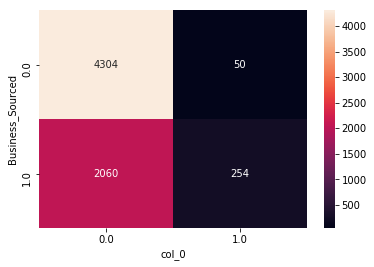

In [29]:
print("Training Confusion Matrix")
sns.heatmap(pd.crosstab(y_train, catboost.predict(X_train)), annot=True, fmt='.0f')

Testing Consfusion Matrix


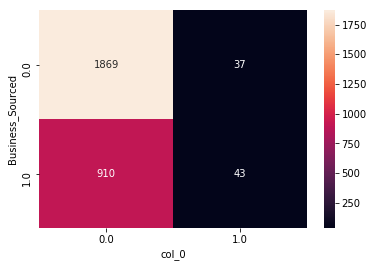

In [30]:
print("Testing Consfusion Matrix")
sns.heatmap(pd.crosstab(y_validation, catboost.predict(X_validation)), annot=True, fmt='.0f')

In [31]:
train_predict=pd.DataFrame(columns=['actual','prob'])
train_predict['actual']=y_train
train_predict['prob']=catboost.predict_proba(X_train)
train_predict.head()

,actual,prob
FIN1003639,0.0,0.648454
FIN1004488,1.0,0.661905
FIN1001684,1.0,0.608438
FIN1001230,0.0,0.740047
FIN1008019,1.0,0.584491


In [32]:
test_predict=pd.DataFrame(columns=['actual','prob'])
test_predict['actual']=y_validation
test_predict['prob']=catboost.predict_proba(X_validation)
test_predict.head()

,actual,prob
FIN1006254,1.0,0.569738
FIN1000397,0.0,0.743163
FIN1007154,1.0,0.596701
FIN1007200,1.0,0.685553
FIN1003265,0.0,0.807853


In [33]:
## Intuition behind ROC curve - confusion matrix for each different cut-off shows trade off in sensitivity and specificity
roc_like_df = pd.DataFrame()
train_temp = train_predict.copy()
i=0
for cut_off in np.linspace(0,1,50):
    train_temp['cut_off'] = cut_off
    train_temp['predicted'] = train_temp['prob'].apply(lambda x: 0.0 if x > cut_off else 1.0)
    train_temp['tp'] = train_temp.apply(lambda x: 1.0 if x['actual']==1.0 and x['predicted']==1 else 0.0, axis=1)
    train_temp['fp'] = train_temp.apply(lambda x: 1.0 if x['actual']==0.0 and x['predicted']==1 else 0.0, axis=1)
    train_temp['tn'] = train_temp.apply(lambda x: 1.0 if x['actual']==0.0 and x['predicted']==0 else 0.0, axis=1)
    train_temp['fn'] = train_temp.apply(lambda x: 1.0 if x['actual']==1.0 and x['predicted']==0 else 0.0, axis=1)
    sensitivity = train_temp['tp'].sum() / (train_temp['tp'].sum() + train_temp['fn'].sum())
    specificity = train_temp['tn'].sum() / (train_temp['tn'].sum() + train_temp['fp'].sum())
    roc_like_table = pd.DataFrame([cut_off, sensitivity, specificity]).T
    roc_like_table.columns = ['cutoff', 'sensitivity', 'specificity']
    roc_like_df = pd.concat([roc_like_df, roc_like_table], axis=0)
    i=i+1


In [34]:
roc_like_df.head()

,cutoff,sensitivity,specificity
0,0.000000,0.0,1.0
0,0.020408,0.0,1.0
0,0.040816,0.0,1.0
0,0.061224,0.0,1.0
0,0.081633,0.0,1.0


In [35]:
import matplotlib.pyplot as plt

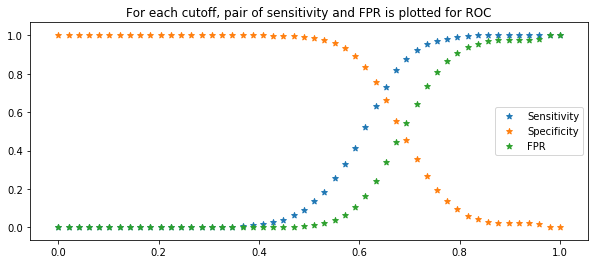

In [36]:
plt.subplots(figsize=(10,4))
plt.scatter(roc_like_df['cutoff'], roc_like_df['sensitivity'], marker='*', label='Sensitivity')
plt.scatter(roc_like_df['cutoff'], roc_like_df['specificity'], marker='*', label='Specificity')
plt.scatter(roc_like_df['cutoff'], 1-roc_like_df['specificity'], marker='*', label='FPR')
plt.title('For each cutoff, pair of sensitivity and FPR is plotted for ROC')
plt.legend()

In [37]:
## Finding ideal cut-off for checking if this remains same in OOS validation
roc_like_df['total'] = roc_like_df['sensitivity'] + roc_like_df['specificity']
roc_like_df[roc_like_df['total']==roc_like_df['total'].max()]

,cutoff,sensitivity,specificity,total
0,0.653061,0.731201,0.661461,1.392662


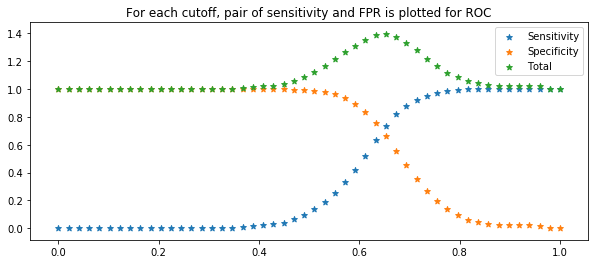

In [39]:
plt.subplots(figsize=(10,4))
plt.scatter(roc_like_df['cutoff'], roc_like_df['sensitivity'], marker='*', label='Sensitivity')
plt.scatter(roc_like_df['cutoff'], roc_like_df['specificity'], marker='*', label='Specificity')
plt.scatter(roc_like_df['cutoff'], roc_like_df['total'] , marker='*', label='Total')
plt.title('For each cutoff, pair of sensitivity and FPR is plotted for ROC')
plt.legend()

In [41]:
cut=round(roc_like_df[roc_like_df['total']==roc_like_df['total'].max()].cutoff[0],5)

In [42]:
test_predict['predicted'] = test_predict['prob'].apply(lambda x: 1 if x < cut else 0)
train_predict['predicted'] = train_predict['prob'].apply(lambda x: 1 if x < cut else 0)

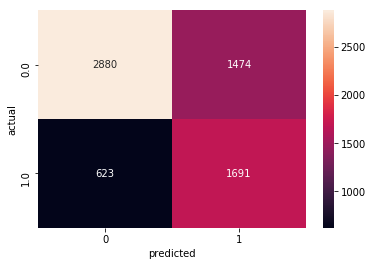

In [43]:
sns.heatmap(pd.crosstab(train_predict['actual'], train_predict['predicted']), annot=True, fmt='.0f')

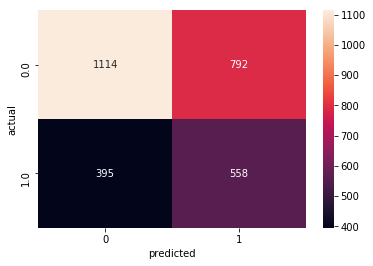

In [44]:
sns.heatmap(pd.crosstab(test_predict['actual'], test_predict['predicted']), annot=True, fmt='.0f')

In [45]:
print("Training roc_auc score is :",metrics.roc_auc_score(train_predict.actual,train_predict.predicted ))
print()
print("Testing roc_auc score is :",metrics.roc_auc_score(test_predict.actual,test_predict.predicted))

Training roc_auc score is : 0.696114978269319

Testing roc_auc score is : 0.5849947534102834


In [46]:
print("The overall accuracy score for the Train Data is : ", metrics.accuracy_score(train_predict.actual,train_predict.predicted ))
print("The overall accuracy score for the Test Data  is : ", metrics.accuracy_score(test_predict.actual,test_predict.predicted))

The overall accuracy score for the Train Data is :  0.6855128974205159
The overall accuracy score for the Test Data  is :  0.5848198670863939


In [47]:
roc_auc_dict = {}
for roc_cutoff in roc_like_df['cutoff'].values:
    roc_auc_dict[roc_cutoff] = {}
    train_metric = train_predict['prob'].apply(lambda x: 1 if x < roc_cutoff else 0)
    roc_auc_dict[roc_cutoff]['train'] = metrics.roc_auc_score(train_predict.actual,train_metric )
    test_metric = test_predict['prob'].apply(lambda x: 1 if x < roc_cutoff else 0)
    roc_auc_dict[roc_cutoff]['test'] = metrics.roc_auc_score(test_predict.actual,test_metric )

In [48]:
roc_df = pd.DataFrame.from_dict(roc_auc_dict,orient='index').reset_index()

In [49]:
roc_df.loc[roc_df['train'].argmax(),:]

index    0.653061
train    0.696331
test     0.584995
Name: 32, dtype: float64

In [50]:
roc_df.loc[roc_df['test'].argmax(),:]

index    0.653061
train    0.696331
test     0.584995
Name: 32, dtype: float64

In [51]:
test_predict['predicted_roc'] = test_predict['prob'].apply(lambda x: 1 if x < 0.653061 else 0)
train_predict['predicted_roc'] = train_predict['prob'].apply(lambda x: 1 if x < 0.653061 else 0)

In [52]:
print("Training roc_auc score is :",metrics.roc_auc_score(train_predict.actual,train_predict.predicted_roc ))
print()
print("Testing roc_auc score is :",metrics.roc_auc_score(test_predict.actual,test_predict.predicted_roc))

Training roc_auc score is : 0.6963310543280917

Testing roc_auc score is : 0.5849947534102834


In [53]:
print("The overall accuracy score for the Train Data is : ", metrics.accuracy_score(train_predict.actual,train_predict.predicted_roc ))
print("The overall accuracy score for the Test Data  is : ", metrics.accuracy_score(test_predict.actual,test_predict.predicted_roc))

The overall accuracy score for the Train Data is :  0.6856628674265147
The overall accuracy score for the Test Data  is :  0.5848198670863939


In [78]:
predicted_test = catboost.predict_proba(test)
predicted_test = [ value[0] for value in predicted_test]
test['Business_Sourced'] = predicted_test
test['Business_Sourced']  = test['Business_Sourced'].apply(lambda x: 1 if x < 0.653061 else 0)